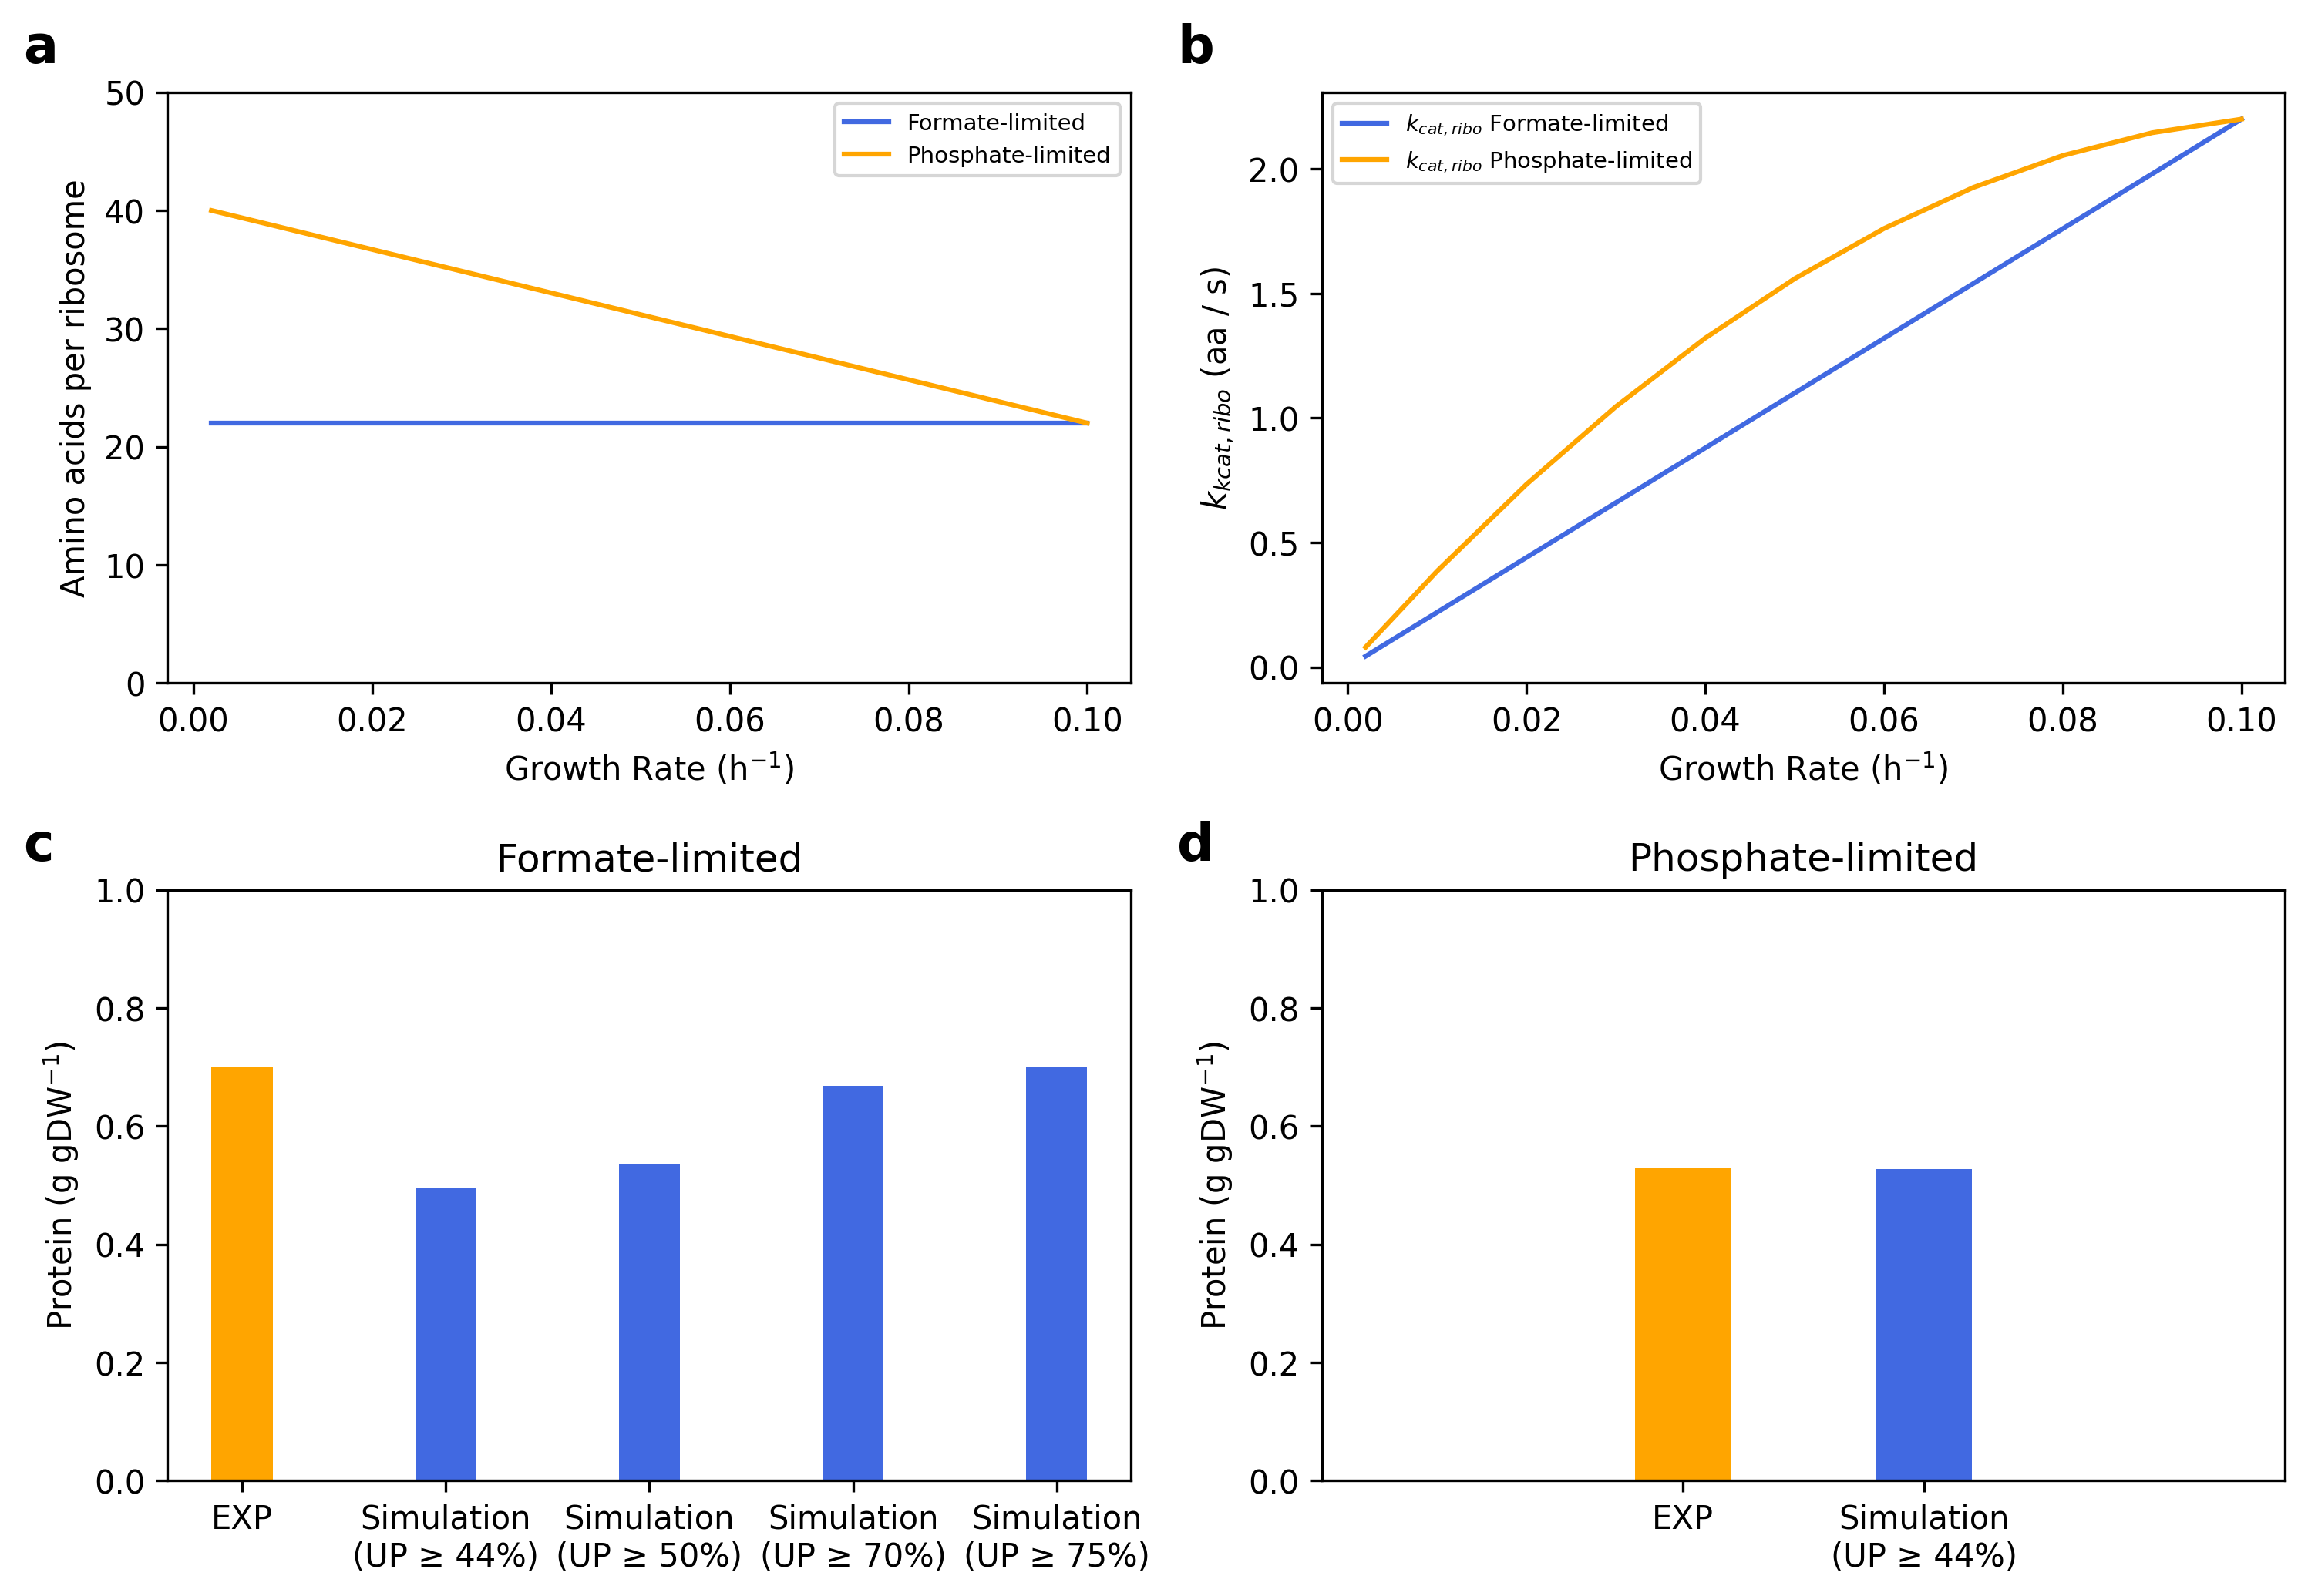

In [1]:
from simulation import Simulation
from extract_fluxes import Fluxes
import cobra
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def limitation_simulation(mu,limitation_type,up_list):
    total_protein_mass=0.6
    methan_id,formate_id = "R944","R895"
    # closed import H2 ,CO2 , CO ,Aceteta
    closed_reactions = ["R946", "R913", "R1165", "R983"]
    sim = Simulation()
     # objective is phosphate
    if limitation_type == "phosphate":
        sim.set_parameter(model_file='pcMMP.xml', objective="R871", GAM=70, NGAM=1, excel_file='pcMMP.xlsx')    
    # objective is formate 
    elif limitation_type == "formate":
        sim.set_parameter(model_file='pcMMP.xml', objective="R895", GAM=25, NGAM=1, excel_file='pcMMP.xlsx')
      
    sim.close_reactions(closed_reactions)
    results = {
        "mu_list": [],"total_proteins": []
    }
    for up in up_list:
        up_ratio=up*total_protein_mass
        sim.set_constraint = [f"UP >={up_ratio}"]
        if limitation_type == "phosphate":
          
            y = -183.67*mu + 40.367
            sim.kcat_ribo = y
        sim.file_path = f"output/lp_file_UP.lp"
        sim.output_file = f"output/output_file_UP.lp"

        if sim.check_mu_optimal(mu):
            fluxes = Fluxes(sim.model, f'output/output_file_UP.lp')
            results["mu_list"].append(mu)
            total_protein = fluxes.extract_reaction_flux("total_protein")
            results["total_proteins"].append(total_protein)
           
        else:
            print(f"mu={mu} is not optimal")

    return results

def plot(results_phosphate,results_formate):
    fig, axs = plt.subplots(2, 2, figsize=(10, 7), dpi=300)
    bar_width = 0.30
   
    plt.rcParams.update({
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "xtick.labelsize":9,
    "ytick.labelsize": 9,
    "legend.fontsize": 7
})
    

    

     
    # 1: ---Estimate amino acids per ribosome----
    mus=np.array([0.002, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09,0.1])
    number_of_aa_per_ribosome_phosphate = -183.67*mus + 40.367
    number_of_aa_per_ribosome_formate = np.repeat(22, len(mus))
    axs[0,0].plot(mus, number_of_aa_per_ribosome_formate, label=r'Formate-limited', color='royalblue')
    axs[0,0].plot(mus, number_of_aa_per_ribosome_phosphate, label=r'Phosphate-limited', color='orange')
    axs[0,0].set_xlabel('Growth Rate (h$^{-1}$)')
    axs[0,0].set_ylabel('Amino acids per ribosome')
    axs[0,0].legend()
    axs[0, 0].set_ylim(0, 50)
    axs[0, 0].text(-0.15, 1.05, 'a', transform=axs[0, 0].transAxes, fontsize=16, fontweight='bold')
    

    # 2: ---Estimate k_ribo----
    kcat_ribo_phosphate = mus * number_of_aa_per_ribosome_phosphate
    kcat_ribo_formate = mus * 22
    axs[0,1].plot(mus, kcat_ribo_formate, label=r'$k_{\mathit{cat,ribo}}$ Formate-limited', color='royalblue')
    axs[0,1].plot(mus, kcat_ribo_phosphate, label=r'$k_{\mathit{cat,ribo}}$ Phosphate-limited', color='orange')
    axs[0,1].set_xlabel('Growth Rate (h$^{-1}$)')
    axs[0,1].set_ylabel(r'$k_{\mathit{kcat,ribo}}$ (aa / s)')
    axs[0,1].legend()
    axs[0, 1].text(-0.15, 1.05, 'b', transform=axs[0, 1].transAxes, fontsize=16, fontweight='bold')
    
    # 3 : Protein – Formate-limited ---
    labels = ["EXP", "Simulation\n(UP ≥ 44%)", "Simulation\n(UP ≥ 50%)","Simulation\n(UP ≥ 70%)", "Simulation\n(UP ≥ 75%)"]
    values = [0.70] + results_formate['total_proteins']
    colors = ["orange"] + ["royalblue"] * 4
    axs[1,0].bar(labels, values, color=colors, width=bar_width)
    axs[1,0].set_ylabel('Protein (g gDW$^{-1}$)')
    axs[1,0].set_title('Formate-limited')
    axs[1,0].set_ylim(0, 1)
    axs[1, 0].text(-0.15, 1.05, 'c', transform=axs[1, 0].transAxes, fontsize=16, fontweight='bold')

    #  4: Protein – Phosphate-limited ---
   
    labels = ["EXP", "Simulation\n(UP ≥ 44%)"]
    values = [0.53] + results_phosphate['total_proteins']
    colors = ["orange", "royalblue"]
    bar_width = 0.04  
    x = 0.5
    space = 0.1    
    x = [x - space/2, x + space/2]
    axs[1, 1].bar(x, values, color=colors, width=bar_width)
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(labels)
    axs[1, 1].set_ylabel('Protein (g gDW$^{-1}$)')
    axs[1, 1].set_title('Phosphate-limited')
    axs[1, 1].set_ylim(0, 1)
    axs[1, 1].set_xlim(0.3, 0.7)  
    axs[1, 1].text(-0.15, 1.05, 'd', transform=axs[1, 1].transAxes, fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig("Figures/Estimate_UP_Kcat_ribo.png", dpi=300)
    plt.show()

if __name__ == "__main__":
    
    up_phopshate_list=[0.44]
    results_phosphate = limitation_simulation(mu=0.089, limitation_type="phosphate",up_list=up_phopshate_list)
    up_formate_list=[0.44, 0.50,0.7, 0.75]
    results_formate = limitation_simulation(mu=0.088, limitation_type="formate",up_list=up_formate_list)
    plot(results_phosphate,results_formate)